In [1]:
from google.colab import drive
drive.mount('/content/drive')

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn, optim
import torch
import os
from PIL import Image

Mounted at /content/drive


In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.transform = transform
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
    
    def __getitem__(self, index):
        image = Image.open(self.images_fps[index])
        mask = Image.open(self.masks_fps[index])
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask[0:1, :, :]
    
    def __len__(self):
        return len(self.ids)

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.maxpool_conv(x)
            
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, 
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, 1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [4]:
path = '/content/drive/MyDrive/side_project/satellite_segmentation/hackthon/image/*.png'
files = glob.glob(path)
print(len(files))
path = '/content/drive/MyDrive/side_project/satellite_segmentation/hackthon/label/*.png'
files = glob.glob(path)
print(len(files))

11200
11200


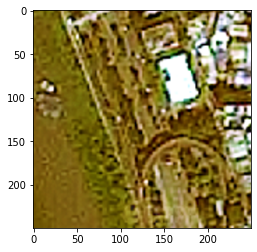

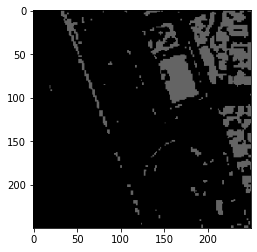

In [5]:
path = '/content/drive/MyDrive/side_project/satellite_segmentation/hackthon/image/output_100_0_0.png'
img = cv2.imread(path)
plt.imshow(img)
plt.show()
path = '/content/drive/MyDrive/side_project/satellite_segmentation/hackthon/label/output_100_0_0.png'
mask = cv2.imread(path)
plt.imshow(mask*100)
plt.show()

In [6]:
train_images_dir = '/content/drive/MyDrive/side_project/satellite_segmentation/hackthon/image/'
train_mask_dir = '/content/drive/MyDrive/side_project/satellite_segmentation/hackthon/label/'
test_images_dir = '/content/drive/MyDrive/side_project/satellite_segmentation/hackthon/image/'
test_mask_dir = '/content/drive/MyDrive/side_project/satellite_segmentation/hackthon/label/'

train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomRotation(degrees=[15, 30]),
                                      transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                      # transforms.GaussianBlur(7, (1, 10)),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.ToTensor()])

satellite_dataset = SatelliteDataset(train_images_dir, train_mask_dir, test_transform)
train_loader = DataLoader(satellite_dataset, batch_size=8, shuffle=True)
satellite_dataset = SatelliteDataset(test_images_dir, test_mask_dir, test_transform)
test_loader = DataLoader(satellite_dataset, batch_size=8, shuffle=False)

In [7]:
path = '/content/drive/MyDrive/side_project/satellite_segmentation/hackthon/unet.pt'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Unet(3, 2).to(device)
net.load_state_dict(torch.load(path))

print(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(10):
    net.train()
    for i, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device).ceil()
        pred = net(image)
        optimizer.zero_grad()
        loss = criterion(pred, label)
        if i % 100 == 99:
            torch.save(net.state_dict(), path)
            print(f'epoch: {epoch+1}, {i+1}, {loss.item()}')

        loss.backward()
        optimizer.step()

cuda:0
epoch: 1, 100, 0.0863313227891922
epoch: 1, 200, 0.16842611134052277
epoch: 1, 300, 0.08060581237077713
epoch: 1, 400, 0.08728320896625519
epoch: 1, 500, 0.11656234413385391
epoch: 1, 600, 0.1329064667224884
epoch: 1, 700, 0.0723995640873909
epoch: 1, 800, 0.08477818220853806
epoch: 1, 900, 0.11513672024011612
epoch: 1, 1000, 0.06313113123178482
epoch: 1, 1100, 0.0965118557214737
epoch: 1, 1200, 0.08944785594940186
epoch: 1, 1300, 0.06590043008327484
epoch: 1, 1400, 0.10720998793840408
epoch: 2, 100, 0.08770229667425156
epoch: 2, 200, 0.08268104493618011
epoch: 2, 300, 0.09239616245031357
epoch: 2, 400, 0.06503984332084656
epoch: 2, 500, 0.07196911424398422
epoch: 2, 600, 0.08094730973243713
epoch: 2, 700, 0.09586535394191742
epoch: 2, 800, 0.11220506578683853
epoch: 2, 900, 0.12144048511981964
epoch: 2, 1000, 0.08074143528938293
epoch: 2, 1100, 0.13486206531524658
epoch: 2, 1200, 0.09632216393947601
epoch: 2, 1300, 0.14516809582710266
epoch: 2, 1400, 0.09689663350582123
epoch: 